In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup
import multiprocessing as mp
import json

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from spinup.algos.pytorch.ddpg.core import MLPActorCritic

%matplotlib notebook

In [2]:
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING
from src import *

In [3]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

t_test = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])
benchmark_error = benchmark_trajectory - test_trajectory

In [4]:
with open('src/data/final_blackbox_trajectory.json') as json_file:
    blackbox_data = json.load(json_file)

blackbox_trajectory = np.array(blackbox_data[' trajectory'])
blackbox_error = np.array(blackbox_data['error'])

In [5]:
with open('src/data/final_dynamic_pid_trajectory.json') as json_file:
    dynpid_data = json.load(json_file)

dynpid_trajectory = np.array(dynpid_data[' trajectory'])
dynpid_error = np.array(dynpid_data['error'])

<IPython.core.display.Javascript object>


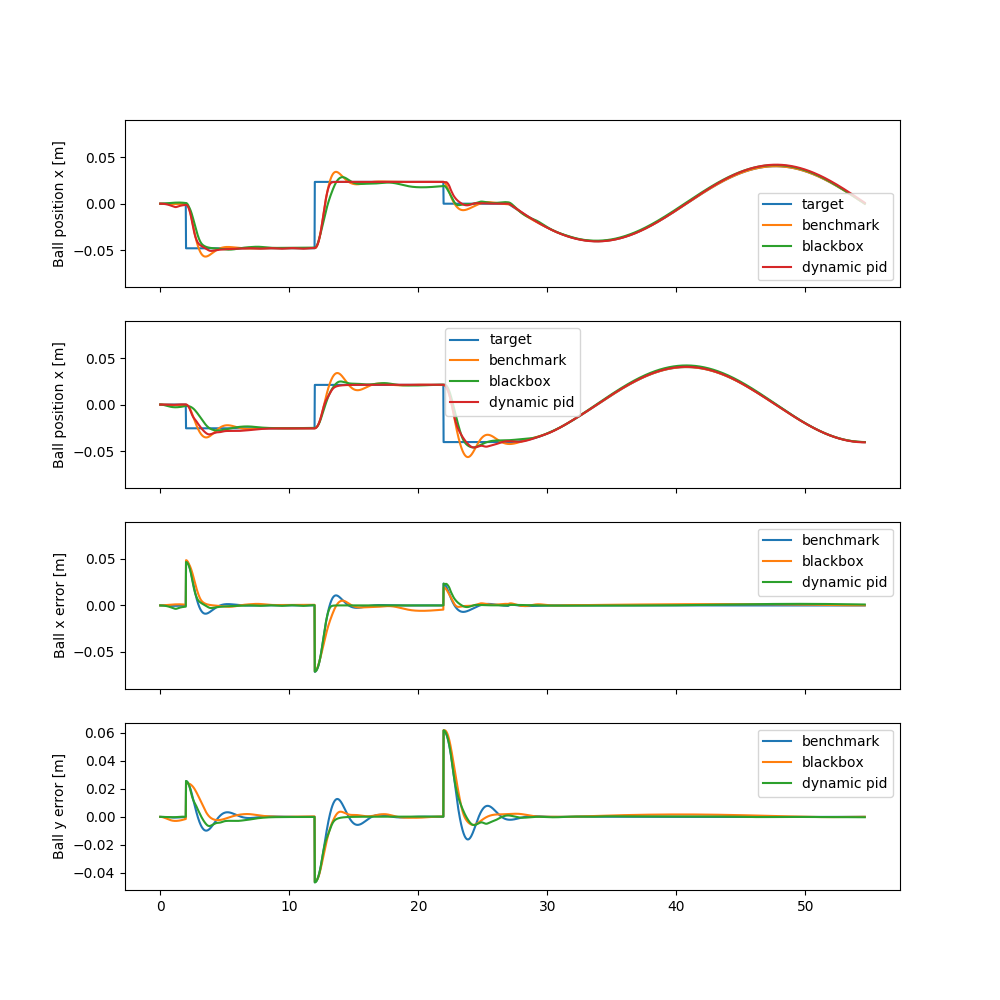

In [6]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t_test, test_trajectory[0, :], label='target')
axs[0].plot(t_test, benchmark_trajectory[0, :], label='benchmark')
axs[0].plot(t_test, blackbox_trajectory[0, :], label='blackbox')
axs[0].plot(t_test,dynpid_trajectory[0, :], label='dynamic pid')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t_test, test_trajectory[1, :], label='target')
axs[1].plot(t_test, benchmark_trajectory[1, :], label='benchmark')
axs[1].plot(t_test, blackbox_trajectory[1, :], label='blackbox')
axs[1].plot(t_test,dynpid_trajectory[1, :], label='dynamic pid')
axs[1].set_ylabel('Ball position x [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t_test, benchmark_error[0, :], label='benchmark')
axs[2].plot(t_test, blackbox_error[0, :], label='blackbox')
axs[2].plot(t_test,dynpid_error[0, :], label='dynamic pid')
axs[2].set_ylabel('Ball x error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t_test, benchmark_error[1, :], label='benchmark')
axs[3].plot(t_test, blackbox_error[1, :], label='blackbox')
axs[3].plot(t_test,dynpid_error[1, :], label='dynamic pid')
axs[3].set_ylabel('Ball y error [m]')
axs[3].legend()

plt.show()

In [7]:
controller = "benchmark"
indexs = [1,2,3,4,5]
benchmark_datas = [pd.read_csv('src/data/real_system_test/{}_record_{}.csv'.format(controller,index)) for index in indexs]
controller = "blackbox"
blackbox_datas = [pd.read_csv('src/data/real_system_test/{}_record_{}.csv'.format(controller,index)) for index in indexs]
controller = "dynpid"
dynpid_datas = [pd.read_csv('src/data/real_system_test/{}_record_{}.csv'.format(controller,index)) for index in indexs]

for controller in [benchmark_datas, blackbox_datas, dynpid_datas]:
    for experiment in controller:
        experiment['x_error'] = experiment['ball_x'] - experiment['target_x']
        experiment['y_error'] = experiment['ball_y'] - experiment['target_y']

In [8]:
print(benchmark_datas[0].head())

   target_x  target_y  ball_x  ball_y  angle_x  angle_y  u_m_x  u_m_y  \
0       0.0       0.0  -0.005    -0.0   -6.991    -4.42 -0.087 -0.286   
1       0.0       0.0  -0.005    -0.0   -6.991    -4.42 -0.103 -0.067   
2       0.0       0.0  -0.005    -0.0   -6.991    -4.42  0.061 -0.123   
3       0.0       0.0  -0.005    -0.0   -6.991    -4.42 -0.051 -0.234   
4       0.0       0.0  -0.005    -0.0   -6.991    -4.42 -0.031 -0.138   

   x_error  y_error  
0   -0.005     -0.0  
1   -0.005     -0.0  
2   -0.005     -0.0  
3   -0.005     -0.0  
4   -0.005     -0.0  


<IPython.core.display.Javascript object>


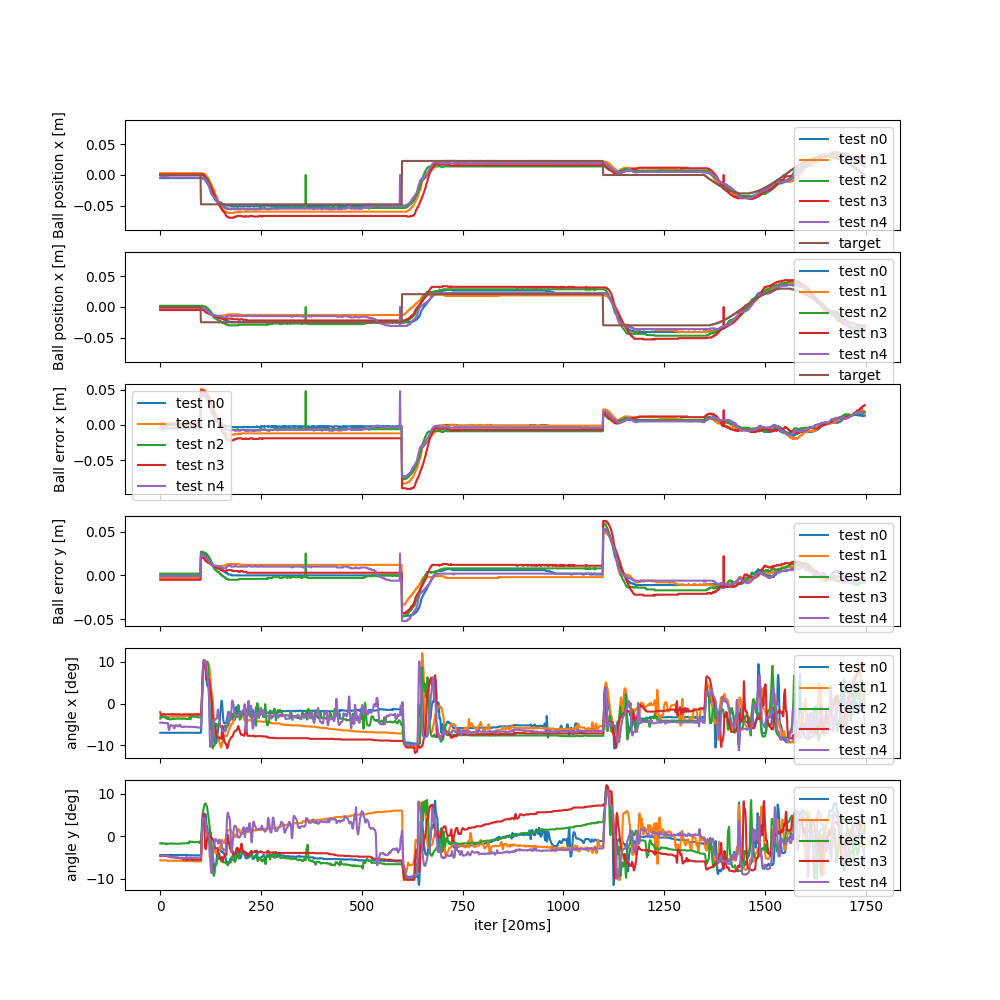

MSE mean: 0.00039219222412807317 
MSE std:  0.00011022744248231411 
MSE std:  0.00011022744248231411 
MSE max:  0.0006047164093767867 	MSE min:  0.00030701429388221846


<IPython.core.display.Javascript object>


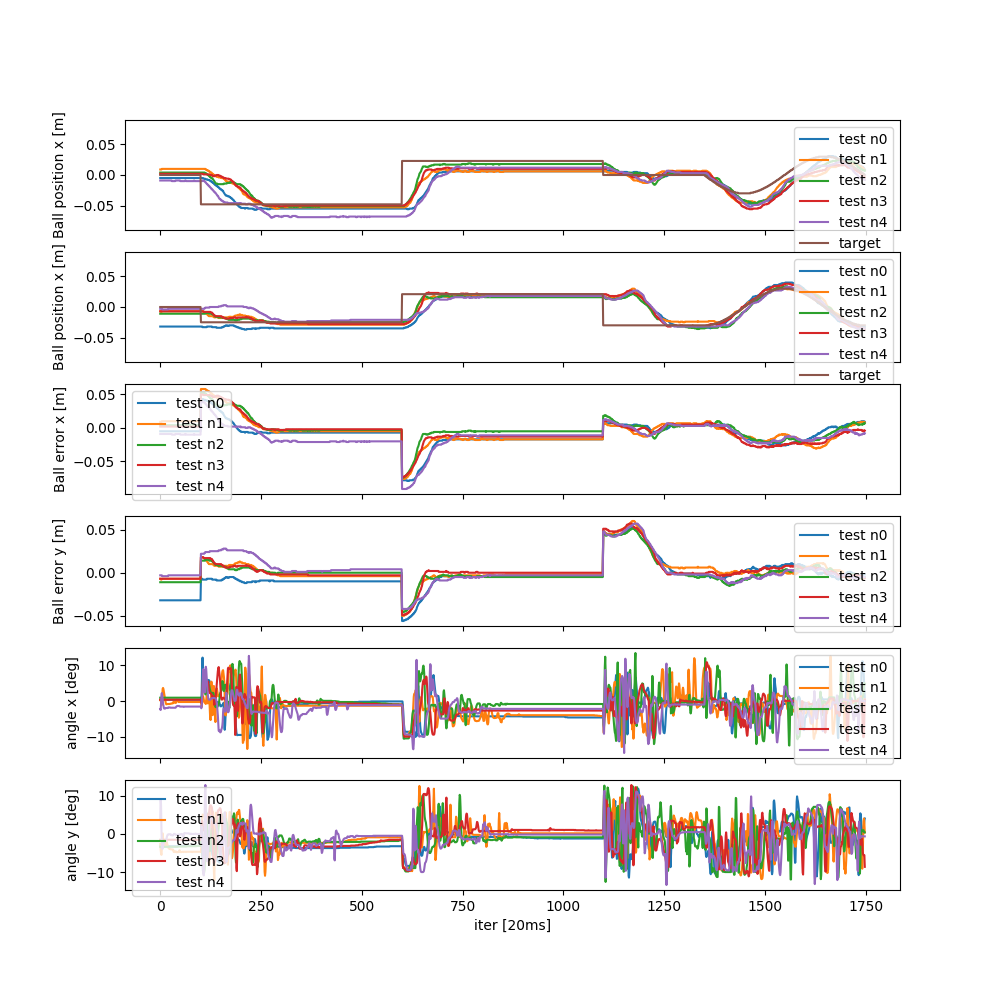

MSE mean: 0.0006027318467695826 
MSE std:  9.562917849359233e-05 
MSE std:  9.562917849359233e-05 
MSE max:  0.0007094768439108063 	MSE min:  0.00044048827901658095


<IPython.core.display.Javascript object>


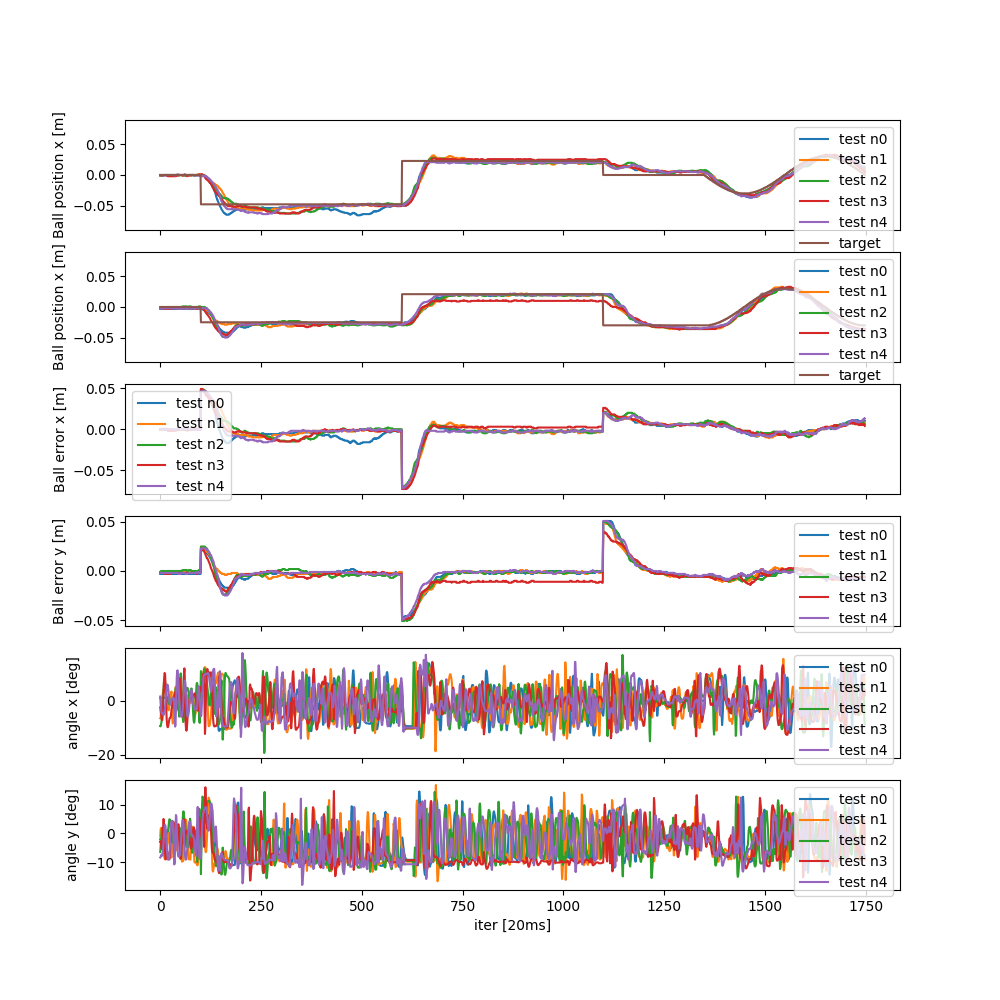

MSE mean: 0.00031334465408805034 
MSE std:  9.283158286988982e-06 
MSE std:  9.283158286988982e-06 
MSE max:  0.00032520583190394516 	MSE min:  0.0002977507146941109


In [9]:
best_controller_index = []
worst_controller_index = []
for controller in [benchmark_datas, blackbox_datas, dynpid_datas]:
    fig, axs = plt.subplots(6, 1, sharex=True, figsize=(10, 10))
    mse = []
    for i, experiment in enumerate(controller):
        axs[0].plot(experiment['ball_x'], label='test n{}'.format(i))
        axs[1].plot(experiment['ball_y'], label='test n{}'.format(i))
        axs[2].plot(experiment['x_error'], label='test n{}'.format(i))
        axs[3].plot(experiment['y_error'], label='test n{}'.format(i))
        axs[4].plot(experiment['angle_x'], label='test n{}'.format(i))
        axs[5].plot(experiment['angle_y'], label='test n{}'.format(i))
        mse.append(-loss(np.vstack((experiment['x_error'].to_numpy(), experiment['y_error'].to_numpy()))))
    axs[0].plot(controller[0]['target_x'], label='target')
    axs[0].set_ylim([-MAX_X, MAX_X])
    axs[0].set_ylabel('Ball position x [m]')
    axs[1].plot(controller[0]['target_y'], label='target')
    axs[1].set_ylim([-MAX_X, MAX_X])
    axs[1].set_ylabel('Ball position x [m]')
    axs[2].set_ylabel('Ball error x [m]')
    axs[3].set_ylabel('Ball error y [m]')
    axs[4].set_ylabel('angle x [deg]')
    axs[5].set_ylabel('angle y [deg]')
    axs[5].set_xlabel('iter [20ms]')
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[3].legend()
    axs[4].legend()
    axs[5].legend()
    plt.show()
    mse = np.array(mse)
    best_controller_index.append(mse.argmin())
    worst_controller_index.append(mse.argmax())
    print('MSE mean:', mse.mean(), '\nMSE std: ', mse.std(), '\nMSE std: ', mse.std(), '\nMSE max: ', mse.max(), '\tMSE min: ', mse.min())

<IPython.core.display.Javascript object>


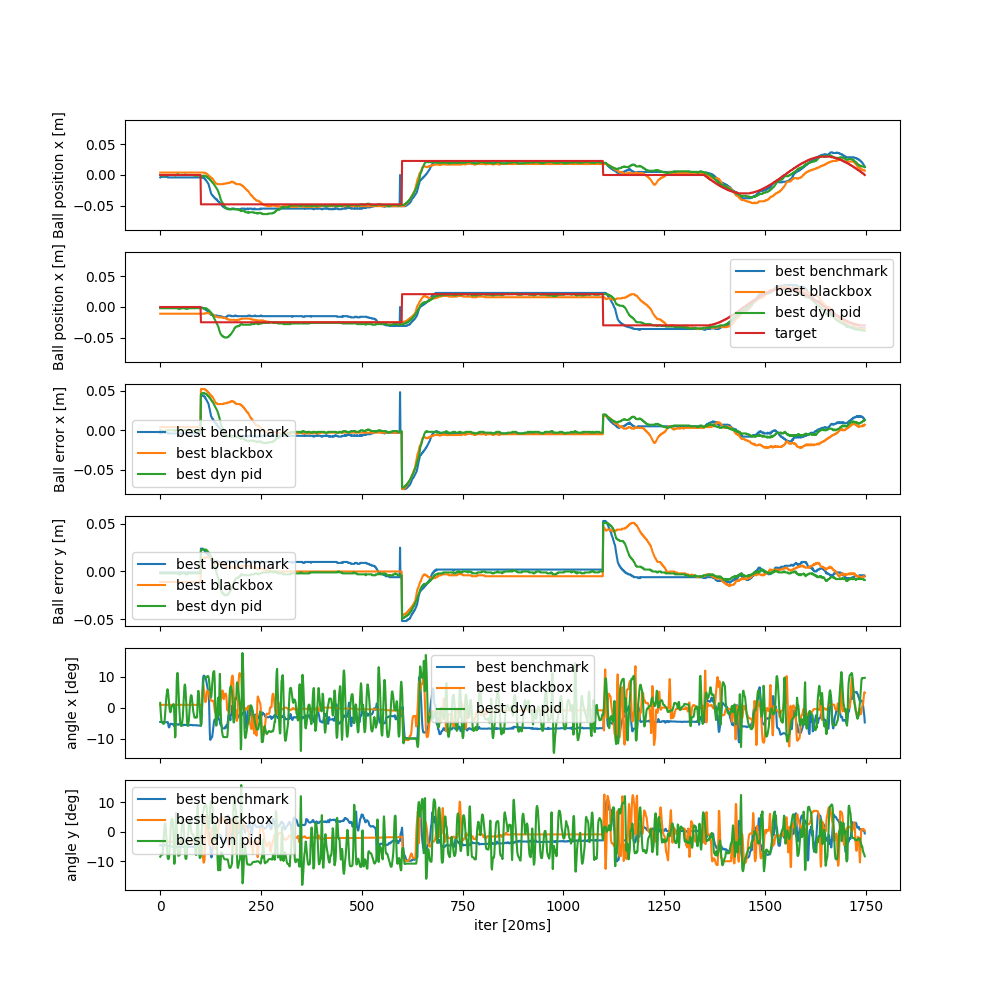

[0.00030701 0.00044049 0.00029775]


In [10]:
fig, axs = plt.subplots(6, 1, sharex=True, figsize=(10, 10))
mse = []
                        
for controller, index, name in zip([benchmark_datas, blackbox_datas, dynpid_datas], best_controller_index, ['benchmark', 'blackbox', 'dyn pid']):
    axs[0].plot(controller[index]['ball_x'], label='best {}'.format(name))
    axs[1].plot(controller[index]['ball_y'], label='best {}'.format(name))
    axs[2].plot(controller[index]['x_error'], label='best {}'.format(name))
    axs[3].plot(controller[index]['y_error'], label='best {}'.format(name))
    axs[4].plot(controller[index]['angle_x'], label='best {}'.format(name))
    axs[5].plot(controller[index]['angle_y'], label='best {}'.format(name))
    mse.append(-loss(np.vstack((controller[index]['x_error'].to_numpy(), controller[index]['y_error'].to_numpy()))))

axs[0].plot(benchmark_datas[0]['target_x'], label='target')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].set_ylabel('Ball position x [m]')
axs[1].plot(benchmark_datas[0]['target_y'], label='target')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].set_ylabel('Ball position x [m]')
axs[2].set_ylabel('Ball error x [m]')
axs[3].set_ylabel('Ball error y [m]')
axs[4].set_ylabel('angle x [deg]')
axs[5].set_ylabel('angle y [deg]')
axs[5].set_xlabel('iter [20ms]')
axs[5].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()
axs[5].legend()
plt.show()
mse = np.array(mse)
print(mse)

<IPython.core.display.Javascript object>


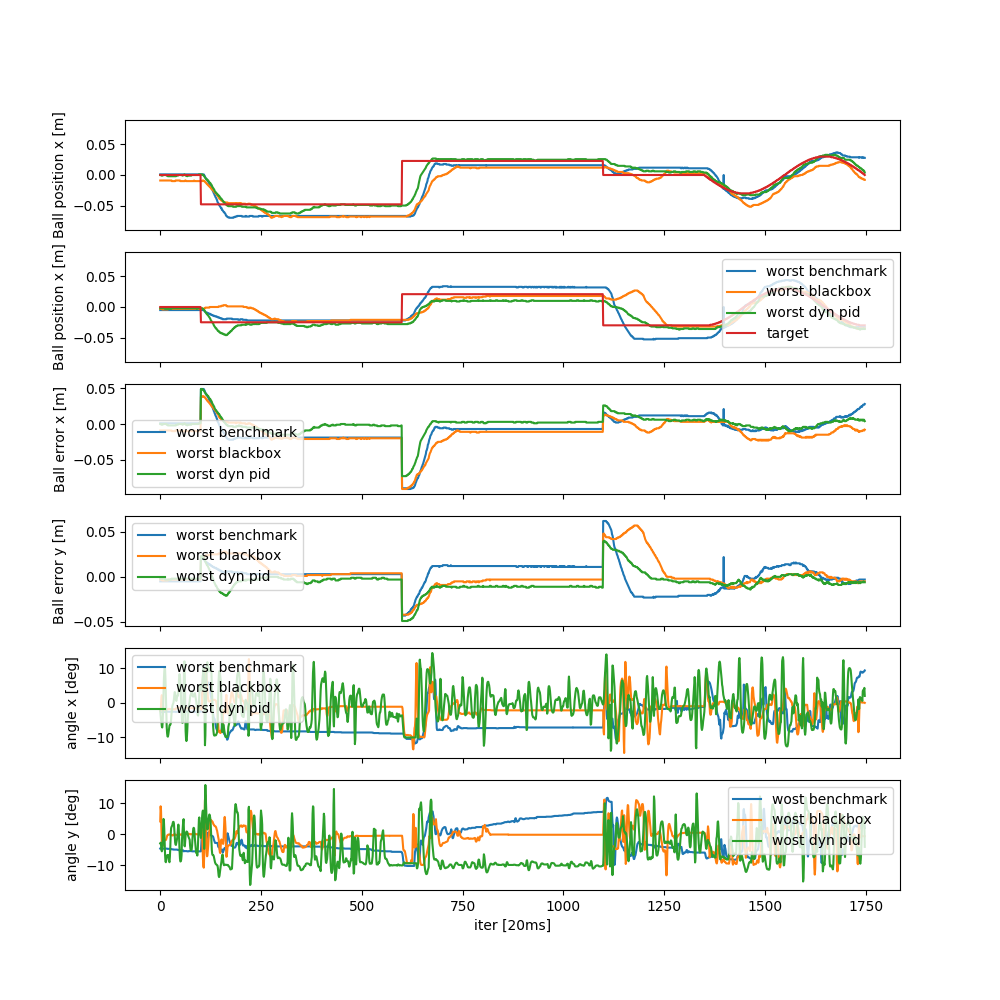

[0.00060472 0.00070948 0.00032521]


In [11]:
fig, axs = plt.subplots(6, 1, sharex=True, figsize=(10, 10))
mse = []
                        
for controller, index, name in zip([benchmark_datas, blackbox_datas, dynpid_datas], worst_controller_index, ['benchmark', 'blackbox', 'dyn pid']):
    axs[0].plot(controller[index]['ball_x'], label='worst {}'.format(name))
    axs[1].plot(controller[index]['ball_y'], label='worst {}'.format(name))
    axs[2].plot(controller[index]['x_error'], label='worst {}'.format(name))
    axs[3].plot(controller[index]['y_error'], label='worst {}'.format(name))
    axs[4].plot(controller[index]['angle_x'], label='worst {}'.format(name))
    axs[5].plot(controller[index]['angle_y'], label='wost {}'.format(name))
    mse.append(-loss(np.vstack((controller[index]['x_error'].to_numpy(), controller[index]['y_error'].to_numpy()))))

axs[0].plot(benchmark_datas[0]['target_x'], label='target')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].set_ylabel('Ball position x [m]')
axs[1].plot(benchmark_datas[0]['target_y'], label='target')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].set_ylabel('Ball position x [m]')
axs[2].set_ylabel('Ball error x [m]')
axs[3].set_ylabel('Ball error y [m]')
axs[4].set_ylabel('angle x [deg]')
axs[5].set_ylabel('angle y [deg]')
axs[5].set_xlabel('iter [20ms]')
axs[5].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()
axs[5].legend()
plt.show()
mse = np.array(mse)
print(mse)

<IPython.core.display.Javascript object>


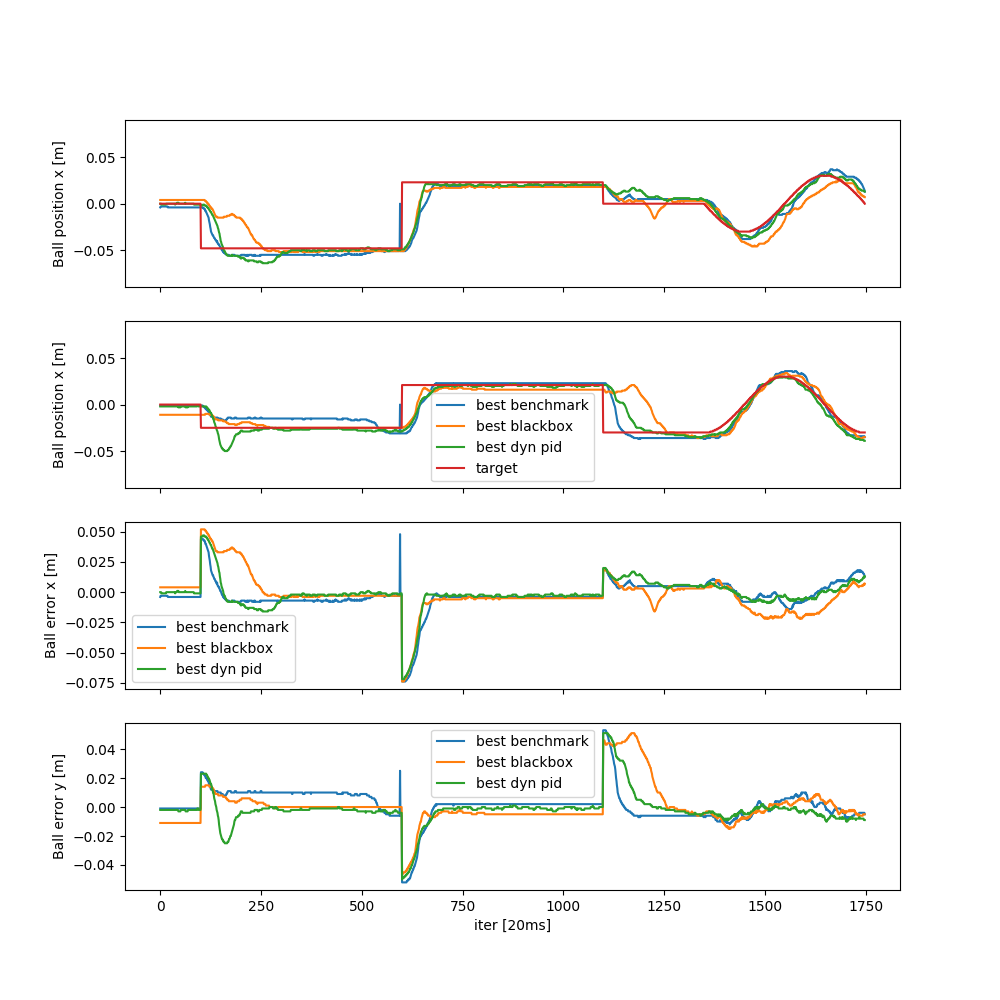

[0.00030701 0.00044049 0.00029775]


In [12]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10, 10))
mse = []
                        
for controller, index, name in zip([benchmark_datas, blackbox_datas, dynpid_datas], best_controller_index, ['benchmark', 'blackbox', 'dyn pid']):
    axs[0].plot(controller[index]['ball_x'], label='best {}'.format(name))
    axs[1].plot(controller[index]['ball_y'], label='best {}'.format(name))
    axs[2].plot(controller[index]['x_error'], label='best {}'.format(name))
    axs[3].plot(controller[index]['y_error'], label='best {}'.format(name))
    mse.append(-loss(np.vstack((controller[index]['x_error'].to_numpy(), controller[index]['y_error'].to_numpy()))))

axs[0].plot(benchmark_datas[0]['target_x'], label='target')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].set_ylabel('Ball position x [m]')
axs[1].plot(benchmark_datas[0]['target_y'], label='target')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].set_ylabel('Ball position x [m]')
axs[2].set_ylabel('Ball error x [m]')
axs[3].set_ylabel('Ball error y [m]')
axs[3].set_xlabel('iter [20ms]')
axs[1].legend()
axs[2].legend()
axs[3].legend()
plt.show()
mse = np.array(mse)
print(mse)

<IPython.core.display.Javascript object>


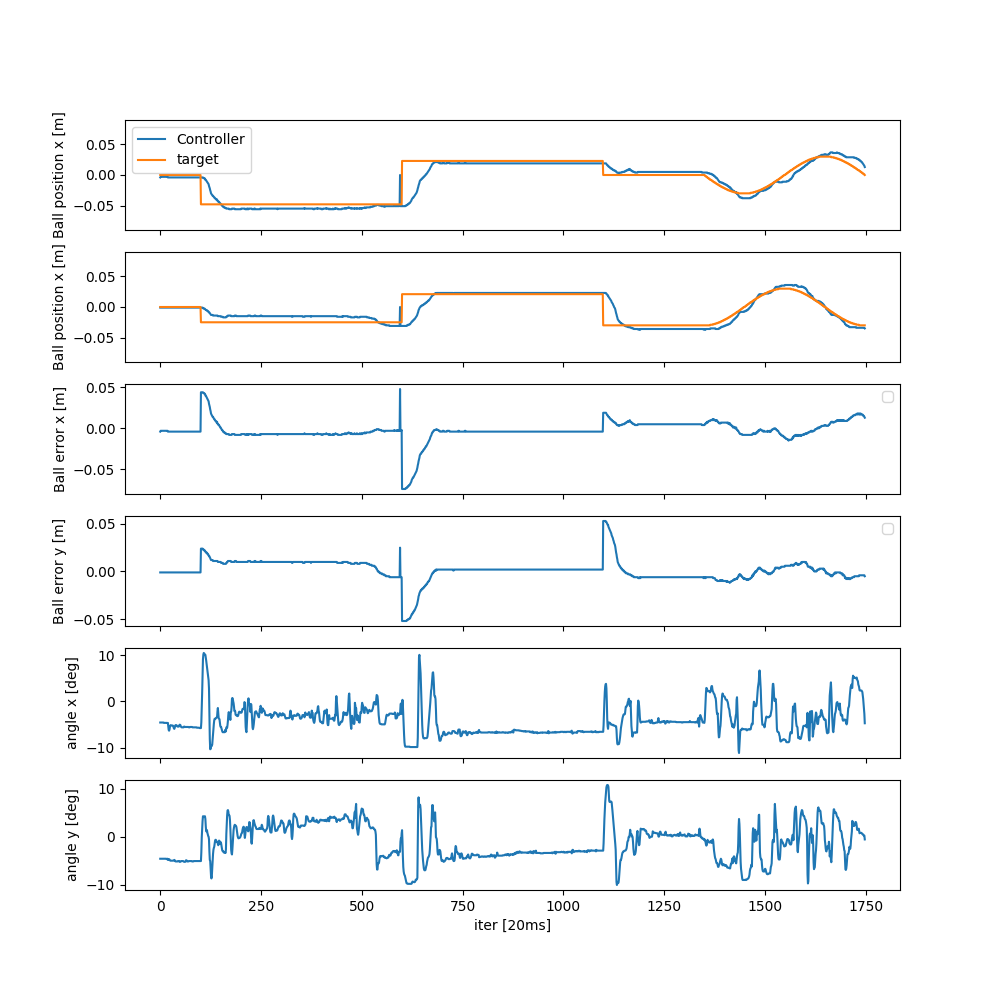

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


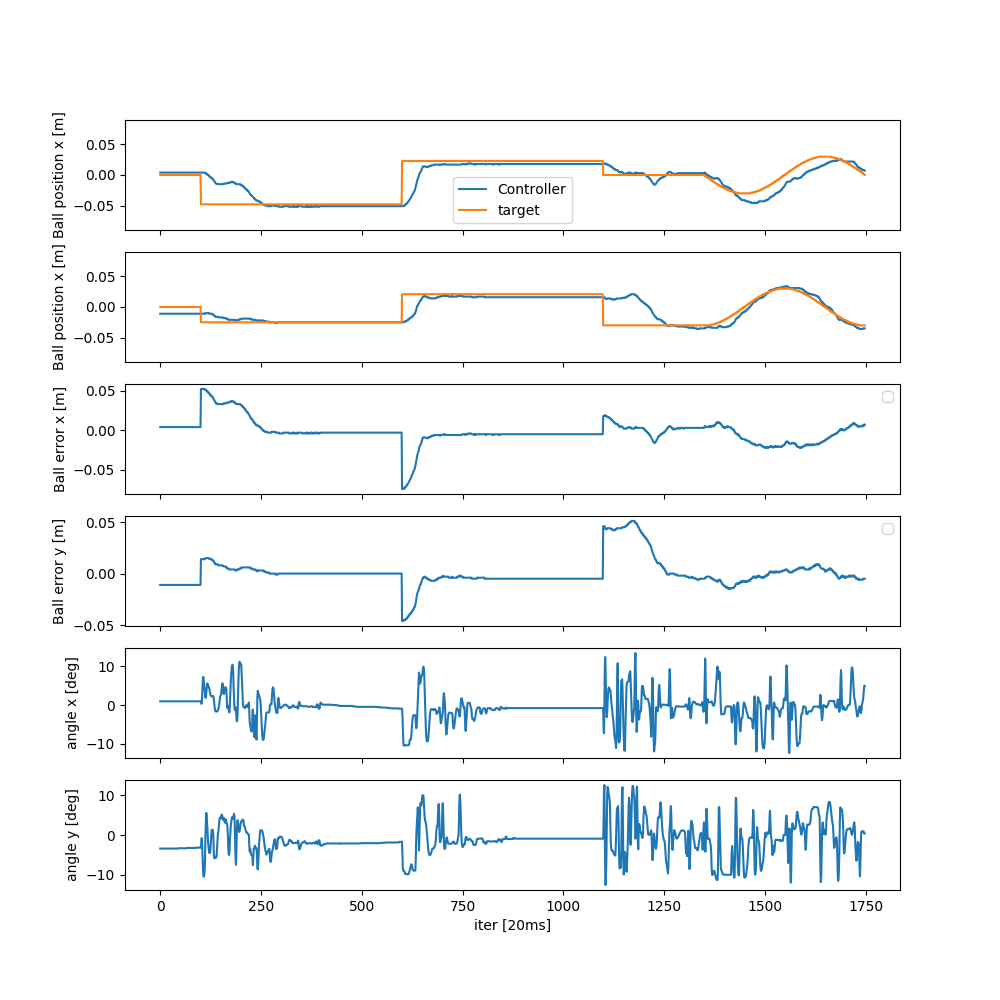

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


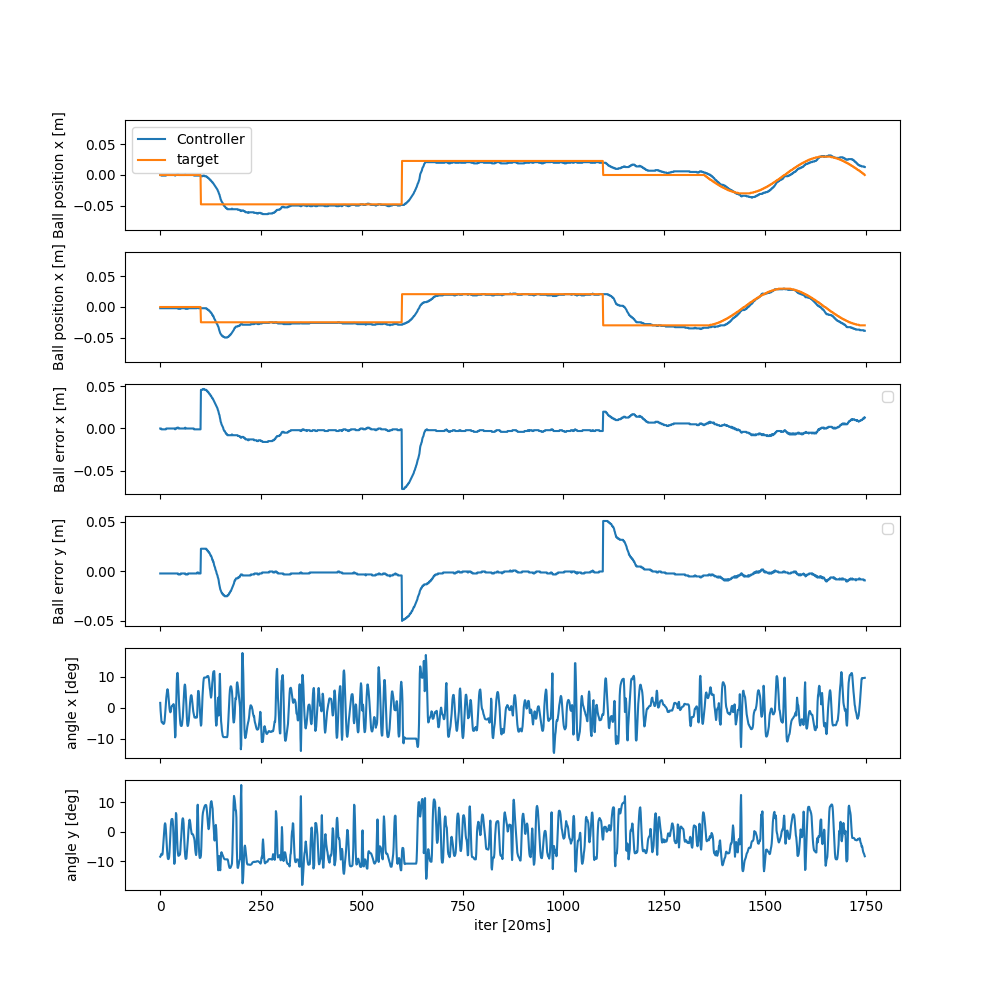

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0.00030701 0.00044049 0.00029775]


In [17]:
mse = []
                        
for controller, index, name in zip([benchmark_datas, blackbox_datas, dynpid_datas], best_controller_index, ['benchmark', 'blackbox', 'dyn pid']):
    fig, axs = plt.subplots(6, 1, sharex=True, figsize=(10, 10))
    axs[0].plot(controller[index]['ball_x'], label='Controller')
    axs[1].plot(controller[index]['ball_y'])
    axs[2].plot(controller[index]['x_error'])
    axs[3].plot(controller[index]['y_error'])
    axs[4].plot(controller[index]['angle_x'])
    axs[5].plot(controller[index]['angle_y'])
    mse.append(-loss(np.vstack((controller[index]['x_error'].to_numpy(), controller[index]['y_error'].to_numpy()))))

    axs[0].plot(benchmark_datas[0]['target_x'], label='target')
    axs[0].set_ylim([-MAX_X, MAX_X])
    axs[0].set_ylabel('Ball position x [m]')
    axs[1].plot(benchmark_datas[0]['target_y'], label='target')
    axs[1].set_ylim([-MAX_X, MAX_X])
    axs[1].set_ylabel('Ball position x [m]')
    axs[2].set_ylabel('Ball error x [m]')
    axs[3].set_ylabel('Ball error y [m]')
    axs[4].set_ylabel('angle x [deg]')
    axs[5].set_ylabel('angle y [deg]')
    axs[5].set_xlabel('iter [20ms]')
    axs[0].legend()
    axs[2].legend()
    axs[3].legend()
    plt.show()
mse = np.array(mse)
print(mse)